In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom
from mpl_toolkits.mplot3d import Axes3D

from time import time

# Question 1

**[20 points]** In class we discussed the use of the Chebyshev differentiation matrix $\tilde{D}^2_N$ when building the Laplacian operator for a square domain $[-1,1]^2$ with $0$ boundary conditions. Our first attempt for the discretization gave us the matrix equation $\tilde{D}^2_N U + U (\tilde{D}^2_N)^T = f(X,Y)$ for $U,\tilde{D}^2_N,f(X,Y) \in \mathbb{R}^{N-1,N-1}$. After some algebraic manipulation and the use of the function $\text{vec}(\cdot)$ we were able to translate the linear system of equation into a classic for $A \vec{x} = \vec{b}$, where $A=L_N = I \otimes \tilde{D}^2_N + \tilde{D}^2_N \otimes I, \vec{x} = \text{vec}(U)$ and $\vec{b} = \text{vec}(f(X,Y))$. Although, it is an elegant solution, we don't really need to build $A$ and $\vec{b}$ to solve the linear system of equations.

---

**a)** Build a matrix-free algorithm based on GMRes that obtains $U$ without requiring to build $A$, i.e. you must only use $\tilde{D}^2_N U $

---

Para resolver este problema creamos una versión de GMRes que en vez de pedir una matriz $A$ directamente, pide una función que debe multiplicar esta matriz $A$ por un vector (o matriz) dada:

Adicionalmente se agrega una flag para indicar si se quieren los valores propios de la matriz de Hessemberg que representa la proyección ortogonal de $A$ en el subespacio de Krylov, es decír, los valores de Ritz.

In [2]:
def gmres_matfree(fnA,b,x0,k=None,get_ritz=False,dtype='float'):
    assert(b.shape==x0.shape)
    
    original_shape = b.shape
    b = b.flatten()
    
    n = b.size
    if k is None: k = n
    
    r0 = b-fnA(x0).flatten()
    r0_norm = np.linalg.norm(r0)
    v0 = r0/r0_norm
    
    V = np.zeros((k+1,n),dtype=dtype)
    V[0] = v0
    
    H = np.zeros((k+1,k),dtype=dtype)
    
    for j in range(k):
        A_vj = fnA(V[j].reshape(original_shape)).flatten()
        
        # stabilized Gram–Schmidt:
        hs = np.zeros((j+1),dtype=dtype)
        for l in range(j+1):
            hs[l] = np.vdot(V[l],A_vj) # Notice complex conjugate
            A_vj -= hs[l]*V[l]
        v_jp1 = A_vj
        
        h_jp1_j = np.linalg.norm(v_jp1)
        v_jp1 = v_jp1/h_jp1_j
        
        V[j+1] = v_jp1
        
        H[:j+1,j] = hs
        H[j+1,j] = h_jp1_j
    
    # Find y_k that minimizes
    bm = np.zeros(k+1,dtype=dtype)
    bm[0] = r0_norm
    ys,res,_,_ = np.linalg.lstsq(H,bm,rcond=None) # a faster alg. may be used.
    xk = x0.flatten() + np.dot(V[:k].T,ys)
    xk = xk.reshape(original_shape)
    
    if get_ritz:
        # Get the eigenvalues of H_n
        eigvals = np.linalg.eigvals(H[:k,:k]) # a faster alg. may be used.
        return xk,eigvals
    else:
        return xk 

In [3]:
# test
N = 5
a = np.random.random((N,N))+np.eye(N)*4
b = np.random.random(N)
fna = lambda x: np.dot(a,x)
for i in range(N+1):
    x0_r = np.zeros(N)
    x_r = gmres_matfree(fna,b,x0_r,k=i)
    print("error %2d iters: "%i+str(np.linalg.norm(x_r-np.linalg.solve(a,b))))

error  0 iters: 0.2457909903553538
error  1 iters: 0.05007105693973002
error  2 iters: 0.012068061001341654
error  3 iters: 0.0003200269619889753
error  4 iters: 8.330517671959657e-06
error  5 iters: 1.2813490069415586e-16


Se crea una función para obtener la matriz de diferenciación para los puntos de Chebyshev.

In [4]:
def cheb_points(n):
    xs = -np.cos(np.pi*np.arange(n)/(n-1))
    return xs

def cheb_diff(n):
    xs = cheb_points(n)
    #
    deltas = xs.reshape(n,1)-xs.reshape(1,n)
    #
    ipj = np.arange(n).reshape((1,n))+np.arange(n).reshape((n,1))
    board = (-1.0)**ipj
    board[:,0] *= 0.5
    board[:,n-1] *= 0.5
    board[0,:] *= 2
    board[n-1,:] *= 2
    #
    d = board/(deltas+np.eye(n))
    res = d-np.diag(np.sum(d,axis=1))
    return res

Hacemos una función que entrega la función que aplica la diferenciación a una matriz $U$ arbitraria de tamaño $n \times n$:

In [5]:
def differentiate_generator(n):
    # Chebyshev diff matrix:
    d_n = cheb_diff(n)
    d2_n = np.dot(d_n,d_n)
    # Function that applies differentiation to a flattened matrix
    def differentiate(u):
        assert(u.shape==(n,n))
        res = np.dot(d2_n,u) + np.dot(u,d2_n.T)
        return res
    return differentiate

Mostramos que la función sirve, generando un problema de ejemplo:
$$
\frac{\partial^2 \mathbf{x}(x,y)}{\partial x^2}= \sin(\pi x) + \cos\left(\tfrac{5}{2} \pi y\right) 
$$

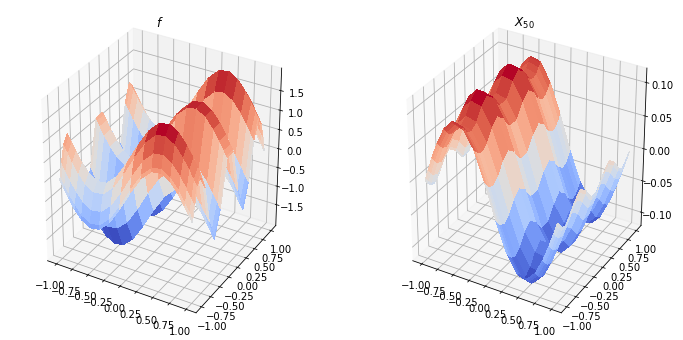

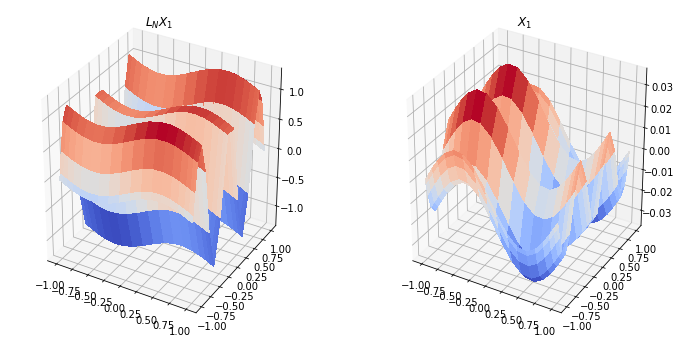

  1 iters rms backward error: 0.05063433666127131
  1 iters rms forward error: 0.505367201422261


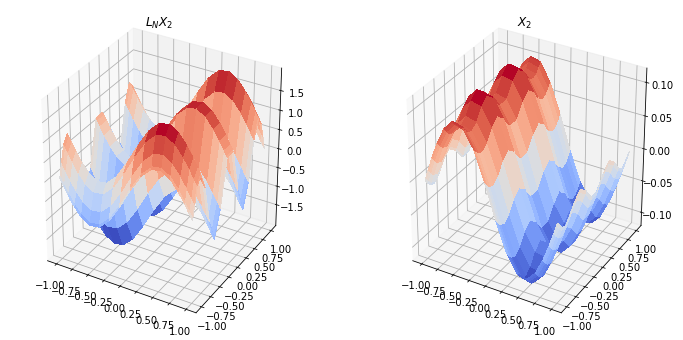

  2 iters rms backward error: 8.347324166481635e-05
  2 iters rms forward error: 0.02054407421774438


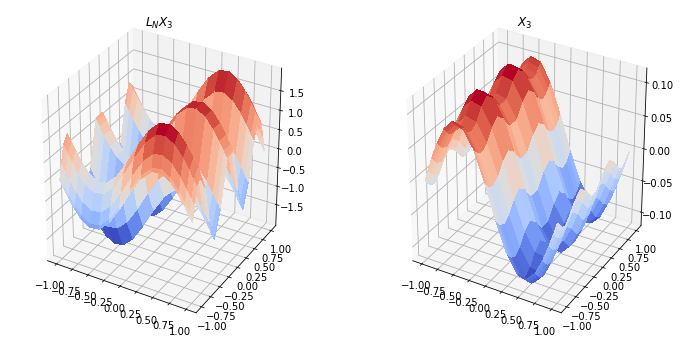

  3 iters rms backward error: 1.2902429036956935e-05
  3 iters rms forward error: 0.0037059113145490787


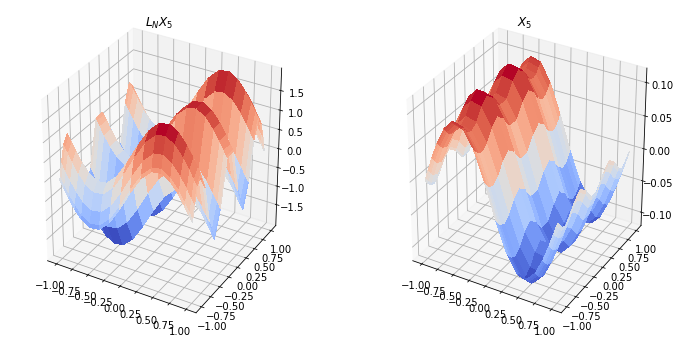

  5 iters rms backward error: 1.92375048840406e-05
  5 iters rms forward error: 0.0009031882247235751


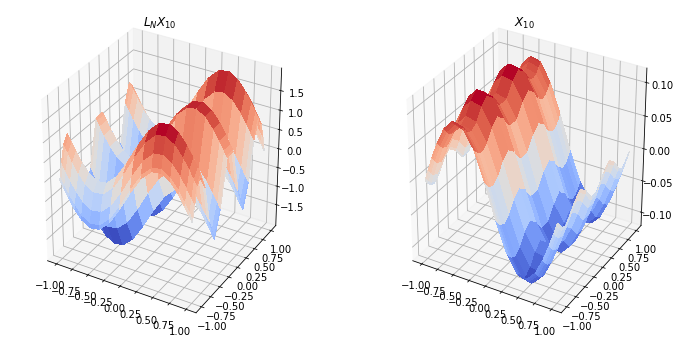

 10 iters rms backward error: 9.484921463833629e-07
 10 iters rms forward error: 0.0005543486074172661


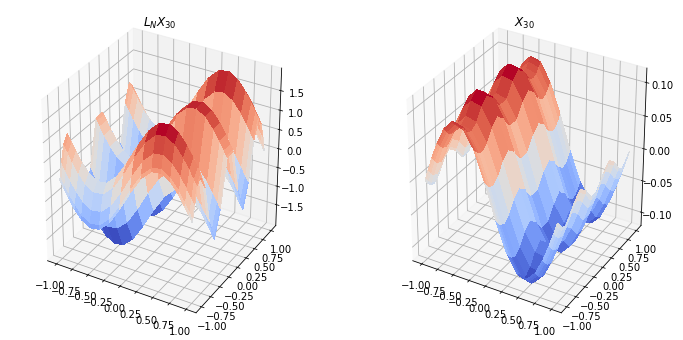

 30 iters rms backward error: 1.0828434622724868e-06
 30 iters rms forward error: 0.0005543467131054994


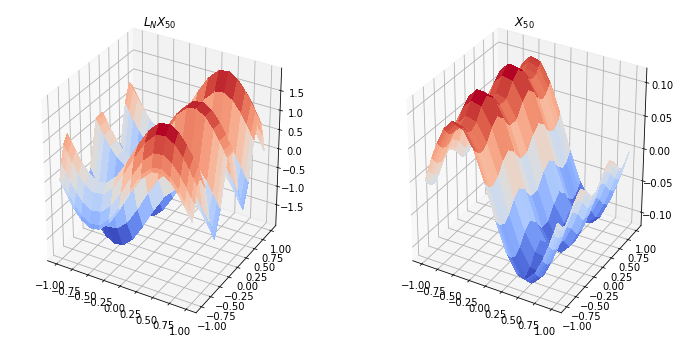

 50 iters rms backward error: 0.0
 50 iters rms forward error: 0.0005543465276333692


In [6]:
N = 20 # size of matrix
xs = np.tile(cheb_points(N),N).reshape((N,N))
ys = xs.T
# Test function:
f = np.sin(1*xs*np.pi)+np.cos(2.5*ys*np.pi)

Xs = {0:np.zeros((N,N))}
k_values = [1,2,3,5,10,30,50] # Can't pick too big due numerical unestability
# We will assume that Xs[k_values[-1]] is the solution

for k in k_values:
    X_k = gmres_matfree(differentiate_generator(N),f,Xs[0],k=k)
    Xs[k] = X_k.real

# Print f
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(xs,ys,differentiate_generator(N)(Xs[k]),
                       cmap=plt.cm.coolwarm,
                       linewidth=0,antialiased=False)
ax.set_title("$f$")
ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(xs,ys,Xs[k_values[-1]],
                       cmap=plt.cm.coolwarm,
                       linewidth=0,antialiased=False)
ax.set_title("$X_{%d}$"%k_values[-1])

# Print errors:
for k in k_values:
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    surf = ax.plot_surface(xs,ys,differentiate_generator(N)(Xs[k]),
                           cmap=plt.cm.coolwarm,
                           linewidth=0,antialiased=False)
    ax.set_title("$L_N X_{%d}$"%k)
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.plot_surface(xs,ys,Xs[k],
                           cmap=plt.cm.coolwarm,
                           linewidth=0,antialiased=False)
    ax.set_title("$X_{%d}$"%k)
    plt.show()
    error = np.sum((Xs[k]-Xs[k_values[-1]])**2/(N*N))**0.5
    print("%3d iters rms backward error: "%k+str(error))
    ferror = np.sum((differentiate_generator(N)(Xs[k])-f)**2/(N*N))**0.5
    print("%3d iters rms forward error: "%k+str(ferror))

Se puede ver que usando GMRes de esta manera se logra una buena convergencia a la solución, y no es necesario construír la matriz $L_N$ de manera explícita.  

---

**b)** Build a matrix-free algorithm based on GMRes that obtains an approximation of the first 10 eigenvalues and eigen-functions of $A$, i.e. you must find an estimation of the igenvalues of $\tilde{D}^2_N U + U (\tilde{D}^2_N)^T$. Compare the approximation obtained with the one computed from $L_N$ derived in class. *Do you recall the Ritz values*?

---

Usamos la función previamente implementada para obtener los 10 primeros valores de Ritz, que son aproximaciones de los valores propios.

Luego por cada valor propio, buscamos la solución a $(A-\lambda I)x = 0$, lo que corresponderá a una eigenfunción. Puesto que los valores propios pueden ser imaginarios, usamos la misma función GMRes que programamos pero con valores complejos.

In [7]:
def approximate_eigenvalues(A,n,k):
    inivals = np.random.random((n,n))*0.0002-0.0001
    X,ritz = gmres_matfree(A,np.zeros((n,n)),inivals,k=k,get_ritz=True)
    return ritz

def eigenfunction_from_eigenvalue(A,n,eigval):
    inivals = np.random.random((n,n))*0.0002-0.0001
    dgen2 = lambda x: A(x)-eigval*np.eye(n)
    eigfun = gmres_matfree(dgen2,np.zeros((n,n)),inivals,k=30,dtype='complex')
    return eigfun

First 10 ritz values:
[ 515.17200185+204.50315944j  515.17200185-204.50315944j
  483.99795585  +0.j          358.89749267+462.84130749j
  358.89749267-462.84130749j   64.55051833+588.15956789j
   64.55051833-588.15956789j -279.39623264+509.2214694j
 -279.39623264-509.2214694j  -431.50229763  +0.j        ]


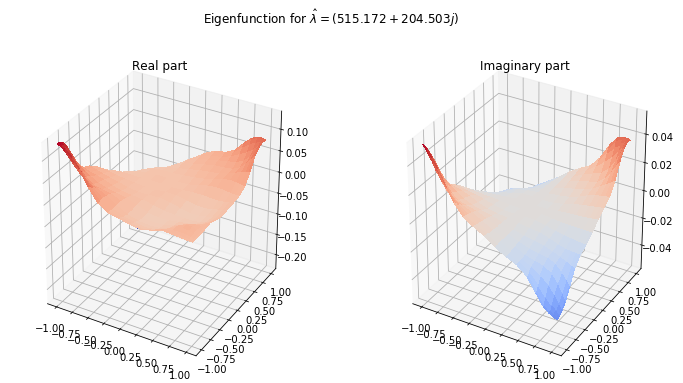

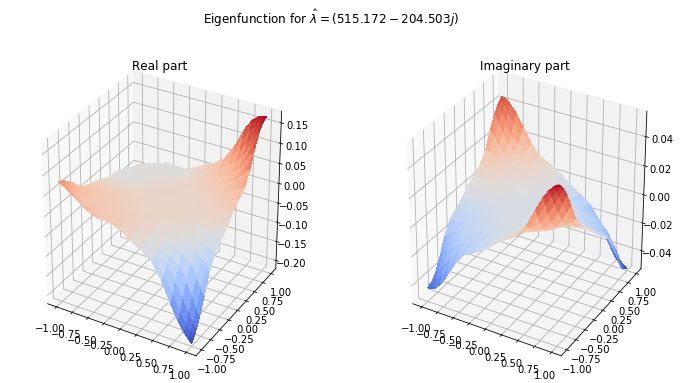

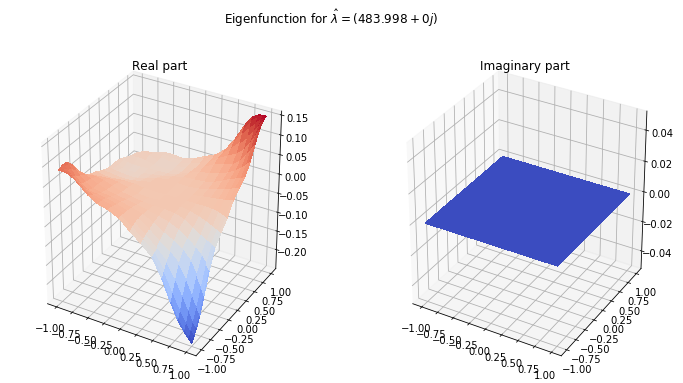

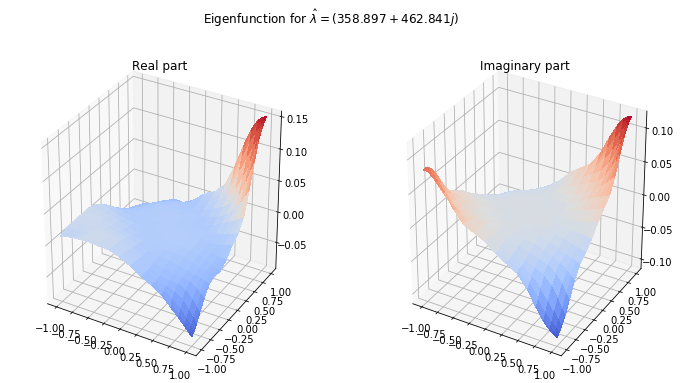

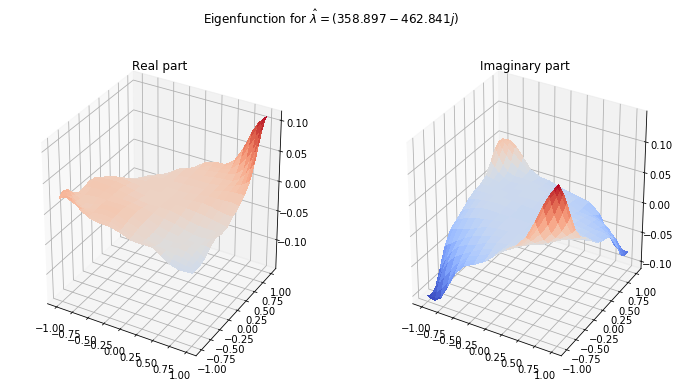

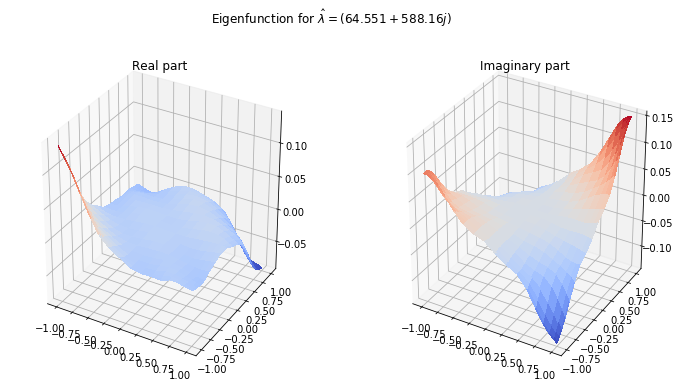

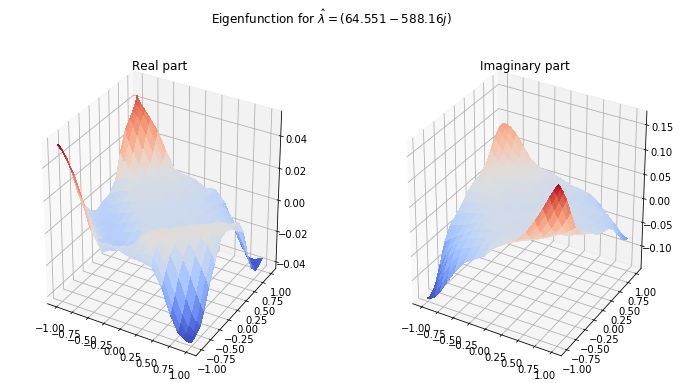

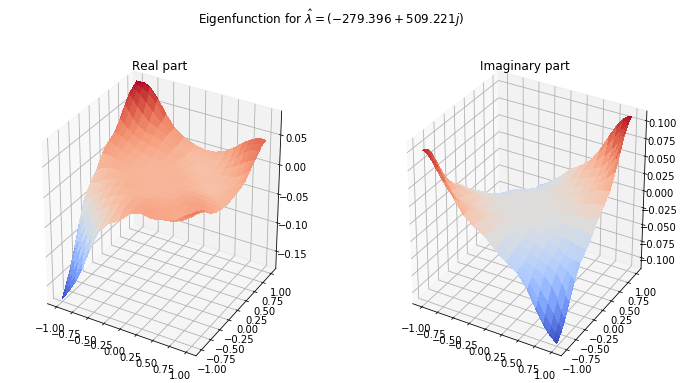

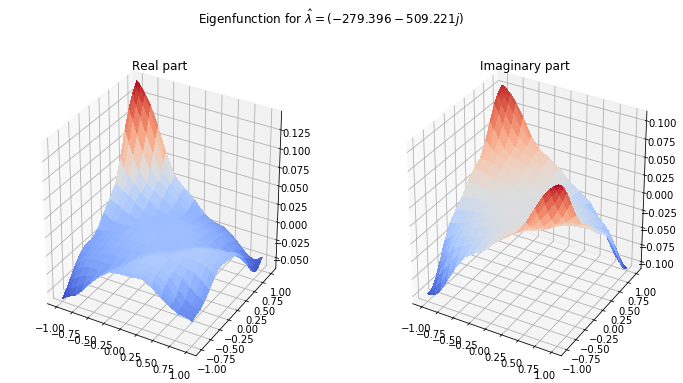

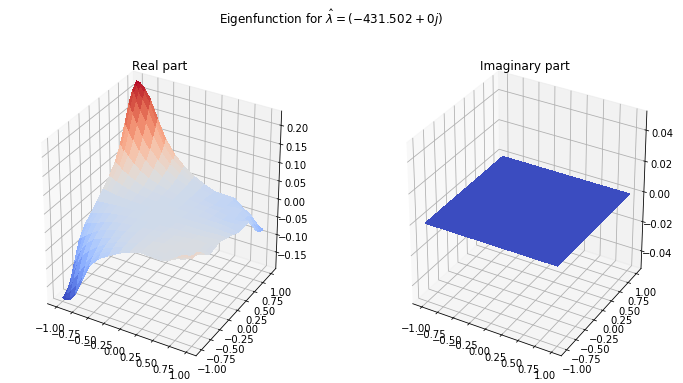

In [8]:
ritz = approximate_eigenvalues(differentiate_generator(N),N,10)

print("First %d ritz values:"%ritz.size)
print(ritz)

for v in ritz:
    # Get the eigenfuction
    xvec = eigenfunction_from_eigenvalue(differentiate_generator(N),N,v)   
    
    fig = plt.figure(figsize=(12,6))
    plt.suptitle("Eigenfunction for $\hat{\lambda}= %s$"%(str(np.round(v,3))))
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.set_title("Real part")
    surf = ax.plot_surface(xs,ys,xvec.real,
                           cmap=plt.cm.coolwarm,
                           linewidth=0,antialiased=False)
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.set_title("Imaginary part")
    surf = ax.plot_surface(xs,ys,xvec.imag,
                           cmap=plt.cm.coolwarm,
                           linewidth=0,antialiased=False)
    plt.show()

Finalmente creamos una función para obtener los valores y funciones propias reales. Para usar `numpy.linalg.eig` es necesario construír la matriz completa:

In [9]:
def differentiate_explicit(n):
    # Chebyshev diff matrix:
    d_n = cheb_diff(n)
    d2_n = np.dot(d_n,d_n)
    # Build matrix
    return np.kron(np.eye(n),d2_n)+np.kron(d2_n,np.eye(n))

In [10]:
eival,eivec = np.linalg.eig(differentiate_explicit(N))
ritzvals = approximate_eigenvalues(differentiate_generator(N),N,10)

print("%20s -> %20s"%("Ritz value","Nearest eigenvalue"))

for rval in ritzvals:
    i = np.argmin(np.abs(eival-rval))
    eiv = np.round(eival[i],3)
    riv = np.round(rval,3)
    print("%20s -> %20s"%(str(riv),str(eiv)))

          Ritz value ->   Nearest eigenvalue
  (536.244+149.312j) ->    (112.655+40.519j)
  (536.244-149.312j) ->    (112.655-40.519j)
  (384.673+398.875j) ->     (82.492+81.537j)
  (384.673-398.875j) ->     (82.492-81.537j)
  (125.306+548.715j) ->    (39.007+102.181j)
  (125.306-548.715j) ->    (39.007-102.181j)
 (-217.837+524.302j) ->    (-15.166+97.691j)
 (-217.837-524.302j) ->    (-15.166-97.691j)
        (125.793+0j) ->         (121.003+0j)
       (-471.796+0j) ->         (-74.624+0j)


Vemos que para este caso los valores de Ritz no aproximan nada bien los eigenvalores de la matriz, sin embargo, a continuación se muestra un caso más pequeño con una matriz mejor condicionada en que esto si sucede.

In [11]:
NNN = 20
matri = np.random.random((NNN,NNN)) + np.eye(NNN)*5

eival,eivec = np.linalg.eig(matri)
ritzvals = approximate_eigenvalues(lambda x: np.dot(matri,x),NNN,10)

print("%20s -> %20s"%("Ritz value","Nearest eigenvalue"))

for rval in ritzvals:
    i = np.argmin(np.abs(eival-rval))
    eiv = np.round(eival[i],3)
    riv = np.round(rval,3)
    print("%20s -> %20s"%(str(riv),str(eiv)))

          Ritz value ->   Nearest eigenvalue
         (14.629+0j) ->          (14.629+0j)
      (5.957+0.087j) ->           (5.979+0j)
      (5.957-0.087j) ->           (5.979+0j)
      (5.295+1.157j) ->       (5.332+1.165j)
      (5.295-1.157j) ->       (5.332-1.165j)
          (3.769+0j) ->           (3.768+0j)
      (4.498+0.846j) ->       (4.318+0.955j)
      (4.498-0.846j) ->       (4.318-0.955j)
      (4.475+0.432j) ->         (4.761+0.5j)
      (4.475-0.432j) ->         (4.761-0.5j)


# Question 4

**[80 points]** Recalling the presentation of FMM in 2D with the potential due to a charge as $\log(z)$, consider 3 clouds of points denoted as $S_1$ ,$S_2$ and $T_1$. The center of cloud $S_1$ in the complex plane is $−p$, the center for cloud $S_2$ is $p \, e^{-i \tfrac{\pi}{4}}$ and the center for $T_1$ is $p$, where $i^2=-1$. All clouds have $N$ points uniformly distributed within a circle of radius $r$ and the charges of $S_1$ and $S_2$ are uniformly distributed following uniform distribution $U(2,10)$.

---

**a)** Propose a numerical algorithm to perform a *fast* sum to evaluate the potential due the source points in cloud $S_1$ over the target points $T_1$ by means of a multipole expansion. The mathematical description of the source points can be written as:
$$
s_1(z) = \sum_{i=1}^N q_i \log(z-z_i).
$$

---

Asumiendo que las nubes no se tocan (para este ítem eso significa que $r < q$):

Se propone utilizar FFM colocando como orígen el centro de $S_1$. El potencial este sistema de coordenadas está entonces dado por:
$$
\phi(x) = \sum_{i=1}^{N} q_i \log(x-z_i') \,,
$$
donde $z_i' = z_i+p$.

Usando FFM este campo es equivalente a:
$$
\phi(x) \approx Q \log(x) + \sum_{k=1}^{P} \frac{a_k}{x^k} \,,
$$
donde
$$
Q = \sum_{i=1}^{N} q_i \qquad \qquad
a_k = \sum_{i=1}^{N} \frac{-q_i (z_i')^{k}}{k} \,.
$$
La aproximación es exacta cuando $P \rightarrow \infty$, pero se pueden calcular menos iteraciones.

Precomputando los $a_k$, que no dependen de $x$, sólo se necesitarían realizar $O(P)$ operaciones por cada uno de los $N$ puntos que se quieren evaluar en el campo. La complejidad final es entonces $O(N P)$, mejor que la $O(N^2)$ original.

Para obtener $s_i(z)$ se hace:
$$
s_i(z) = \phi(z+p)
$$

---

**b)** Implement in a Jupyter Notebook the previous fast-sum and show it reduces the computational complexity as $N$ increases, show how the error changes and test how the approximation depends on $p$ and $r$.

*Hint: I suggest to keep $r = 1$ and only vary $p$ conveniently. Notice that if $p$ is large enough, the approximation should be good so it would be interesting to see what happens when the clouds approach each other!*

*Hint 2: An error vs computation time plot would be good.*

---

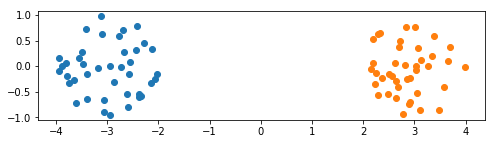

In [12]:
def point_cloud(N,rad=1):
    angles = 2*np.pi*np.random.random(N)
    poss = np.random.random(N)**0.5*rad*np.exp(1j*angles)
    return poss

def charges(N,minc,maxc):
    return minc+np.random.random(N)*(maxc-minc)

# Generate and plot points for a given p and N
def run_4b_1(): # just so the variables aren't created on global scope.
    p = 3
    N = 40
    pts_s1 = point_cloud(N)-p
    pts_t = point_cloud(N)+p
    pts_s1_q = charges(N,2,10)

    plt.figure(figsize=(8,6))
    plt.plot(np.real(pts_s1),np.imag(pts_s1),'o')
    plt.plot(np.real(pts_t),np.imag(pts_t),'o')
    plt.axis('scaled')
    plt.show()

run_4b_1()

In [13]:
# Compute the potential using the direct method
def direct_potential(srcs,srcs_q,trgts):
    fields = np.zeros(trgts.size)+0j
    for i in range(len(trgts)):
        t = trgts[i]
        deltas = t-srcs
        fields[i] = np.sum(np.log(deltas+0j)*srcs_q)
    return fields

# Compute the potential using fast multipole method
def fmm_potential(srcs,srcs_q,trgts,p=6):
    # sum of chargues
    qq = np.sum(srcs_q)
    # z_i^k powers:
    ziks = np.expand_dims(srcs,-1)**np.arange(1,p+1)
    # each a_k term (for k>=1):
    aks_terms = -ziks*np.expand_dims(srcs_q,-1)/np.arange(1,p+1)
    # a_k's:
    aks = np.sum(aks_terms,axis=0)
    # compute the z^k for each target:
    zk = np.expand_dims(trgts,-1)**np.arange(1,p+1)
    # get the fields for each target
    zs = qq*np.log(trgts+0j) + np.sum(aks/zk,axis=1)
    return zs

In [14]:
def compute_approx_errors_and_time(N,p,P_values,n_tests=10):

    real_times = []
    fmm_times = []
    fmm_errors = []

    # Compute metrics for several tests
    for n in range(n_tests):
        fmm_times.append([])
        fmm_errors.append([])

        pts_s1 = point_cloud(N)-p
        pts_t = point_cloud(N)+p
        pts_s1_q = charges(N,2,10)

        # compute right potential
        start = time()
        real_field = direct_potential(pts_s1,pts_s1_q,pts_t)
        real_times.append(time()-start)

        # compute approximation for fmm increasing the number of terms
        for P in P_values:
            start = time()
            fmm_field = fmm_potential(pts_s1+p,pts_s1_q,pts_t+p,P) # note relativization
            fmm_times[-1].append(time()-start)

            # compute mean relative error
            error = np.abs(fmm_field-real_field)/np.abs(real_field)
            error = np.mean(error)
            fmm_errors[-1].append(error)

    # mean of errors and times over tests
    fmm_errors = np.mean(fmm_errors,axis=0)
    fmm_times = np.mean(fmm_times,axis=0)
    real_times = np.mean(real_times,axis=0)

    return fmm_errors, fmm_times, real_times

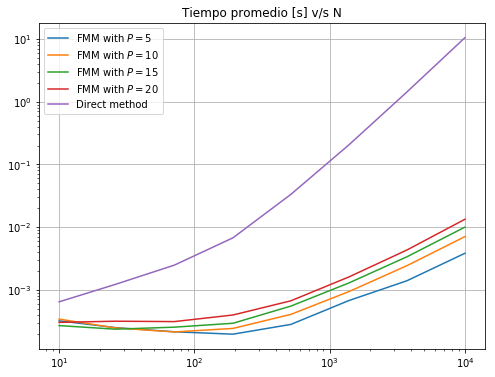

In [15]:
def mean_times_vs_n(computation):    
    
    # --- Times depend on N and P
    P_values = range(5,21,5)
    n_values = np.logspace(1,4,8).astype('int')
    real_ts = []
    fmm_ts = []
    for nn in n_values:
        # print("Computing for n=%d"%(nn))
        _, fmm_t, real_t = computation(nn,4.0,P_values=P_values)
        real_ts.append(real_t)
        fmm_ts.append(fmm_t)
    real_ts = np.array(real_ts)
    fmm_ts = np.array(fmm_ts)
    
    plt.figure(figsize=(8,6))
    for i in range(len(P_values)):
        plt.plot(n_values,fmm_ts[:,i],label="FMM with $P{=}%d$"%P_values[i])
    plt.plot(n_values,real_ts,label="Direct method")
    plt.xscale('log')
    plt.yscale('log')
    plt.title("Tiempo promedio [s] v/s N")
    plt.legend()
    plt.grid()
    plt.show()
        
mean_times_vs_n(compute_approx_errors_and_time)

Se puede ver que conforme $N$ aumenta, el tiempo requerido para el método directo aumenta considerablemente, mientras que para FMM crece bastante lento, aumentar $P$ sólo aumenta el tiempo en un factor. 

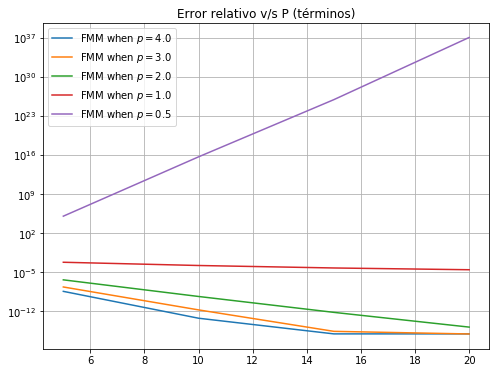

In [16]:
def rel_error_vs_P(computation):    
    
    # --- Errors depend on p (distance) and P (terms)
    P_values = range(5,21,5)
    N = 1000
    errors_ts = []
    p_values = [4.0,3.0,2.0,1.0,0.5]
    for pp in p_values:
        error_t,_,_ = computation(N,pp,P_values=P_values)
        errors_ts.append(error_t)
    fmm_ts = np.array(error_t)
    
    plt.figure(figsize=(8,6))
    for i in range(len(p_values)):
        plt.plot(P_values,errors_ts[i],label="FMM when $p{=}%.1f$"%p_values[i])
    plt.title("Error relativo v/s P (términos)")
    plt.legend()
    plt.grid()
    plt.yscale('log')
    plt.show()
        
rel_error_vs_P(compute_approx_errors_and_time)

Usando $r=1$, se puede ver que cuando $p<1$ el error aumenta con más términos (mayor $P$). Cuando $p=1$ se mantiene constante (las nubes se tocan) y cuando $p>1$ converge, más rápido mientras mayor sea $p$.

---

**c)** Propose a numerical algorithm to perform a fast sum to evaluate the potential due the source points in cloud $S_1$ and $S_2$ over the target points $T_1$ by means of going from two multipole expansion to a power series.

---

Para cada una de las nubes de cargas:
* Se obtienen los coeficientes $a_i$ considerando como origen el centro de la nube.
* Se obtienen los coeficientes $b_l$ de la serie de potencias, moviendo el sistema de coordenadas de manera que el orígen es el centro de la nube $T_1$, resultando en la expresión:
$$
\phi(z)^{(i)} \approx \sum_{l=0}^Q {b_l^{(i)}} (z-p)^l
$$
para la nube $S_i$, donde los $b_l^{(i)}$ se calculan como:
$$
b_0^{(i)} = \sum_{k=1}^{P} \frac{a_k^{(i)}}{(z_0^{(i)}-p)^k} (-1)^k + a_0^{(i)} \log(-z_0^{(i)}+p)
$$
$$
b_l^{(i)} = \left( \frac{1}{(z_0^{(i)}-p)^l} \sum_{k=1}^{Q} \frac{a_k^{(i)}}{(z_0^{(i)}-p)^k} \binom{l+k-1}{k-1} (-1)^k \right) - \frac{a_0}{l (z_0^{(i)}-p)^l}
$$
donde $z_0^{(i)}$ es el centro de la nube $S_i$.

Finalmente se aproxima el campo para los puntos cerca de $T_1$ como:
$$
\phi(z) = \sum_{l=0}^Q (b_l^{(1)}+b_l^{(2)}) (z-p)^l
$$
donde $T = p$ es el centro de la nube $T_1$.

---

**d)** Implement in Jupyter Notebook the previous fast-sum and show it reduces the computational complexity as N
increases. Also test how the approximation depends on ρ and r. Hint: Same hints from (b) are valid here.

---

In [17]:
# Compute the local taylor series coefficients for targets near the origin,
# where z0 is the center of the sources
def local_taylor_series_coefs(z0,srcs,srcs_q,p=6,q=6):
    # relativize sources to their center
    srcs -= z0
    # sum of chargues
    a0 = np.sum(srcs_q)
    # z_i^k powers:
    ziks = np.expand_dims(srcs,-1)**np.arange(1,p+1)
    # each a_k term (for k>=1):
    aks_terms = -ziks*np.expand_dims(srcs_q,-1)/np.arange(1,p+1)
    # a_k's:
    aks = np.sum(aks_terms,axis=0)
    # ---
    # compute the z0^k 's:
    z0k_p = z0**np.arange(1,p+1)
    z0k_q = z0**np.arange(1,q+1)
    # binomial coefficients for b_l. NOTE: this could be optimized using dynamic prog.
    binoms = [[binom(l+k-1,k-1) for k in range(1,p+1)] for l in range(1,q+1)]
    binoms = np.array(binoms)
    # compute b_l's
    b0 = np.sum(aks/z0k_p*(-1)**np.arange(1,p+1))+a0*np.log(-z0)
    bls = (1/z0k_q)*np.sum(aks/z0k_p*binoms*(-1)**np.arange(1,p+1),axis=1)
    bls -= a0/(np.arange(1,q+1)*z0k_q)
    return np.concatenate( ([b0],bls) )
    
def eval_coefs(coefs,trgts):
    # compute the z^k for each target:
    qp1 = np.shape(coefs)[0]
    zk = np.expand_dims(trgts,-1)**np.arange(qp1)
    # multiply the coefficients and sum
    return np.sum(zk*coefs,axis=1)

In [18]:
def compute_approx_errors_and_time_2(N,p,P_values,n_tests=10):
    
    real_times = []
    fmm_times = []
    fmm_errors = []

    # Compute metrics for several tests
    for n in range(n_tests):
        fmm_times.append([])
        fmm_errors.append([])

        z01 = -p
        z02 = p*np.exp(np.pi/4*1j)
        z0t = p
        pts_s1 = point_cloud(N)+z01
        pts_s2 = point_cloud(N)+z02
        pts_t = point_cloud(N)+z0t
        pts_s1_q = charges(N,2,10)
        pts_s2_q = charges(N,2,10)

        # compute right potential
        start = time()
        real_field = direct_potential(pts_s1,pts_s1_q,pts_t)
        real_field += direct_potential(pts_s2,pts_s2_q,pts_t)
        real_times.append(time()-start)

        # compute approximation for fmm increasing the number of terms
        for P in P_values:
            start = time()
            # Get series expansion coefficients from both source clouds and add them
            coefs = local_taylor_series_coefs(z01-z0t,pts_s1-z0t,pts_s1_q,p=P,q=P)
            coefs += local_taylor_series_coefs(z02-z0t,pts_s2-z0t,pts_s2_q,p=P,q=P)
                                                  # Note than we are making p=q=P
            # Evaluate coefficients
            fmm_field = eval_coefs(coefs,pts_t-z0t)
            
            fmm_times[-1].append(time()-start)
            # compute mean relative error
            error = np.abs(fmm_field-real_field)/np.abs(real_field)
            error = np.mean(error)
            fmm_errors[-1].append(error)

    # mean of errors and times over tests
    fmm_errors = np.mean(fmm_errors,axis=0)
    fmm_times = np.mean(fmm_times,axis=0)
    real_times = np.mean(real_times,axis=0)

    return fmm_errors, fmm_times, real_times

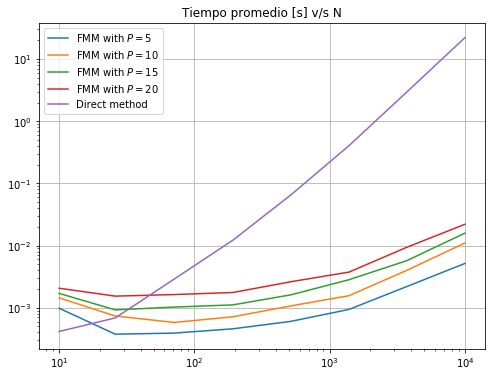

In [19]:
mean_times_vs_n(compute_approx_errors_and_time_2)

De este gráfico podemos obtener las mismas conclusiones para los tiempos que en 4.b, sólo que aquí se están usando las series de Taylor locales. 

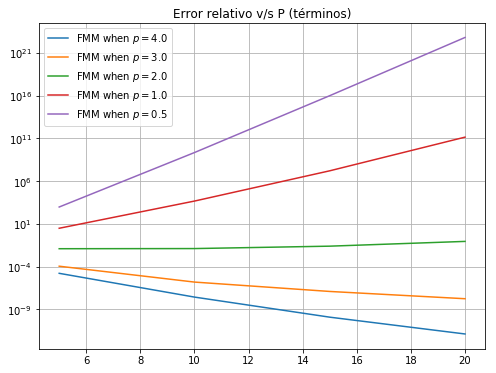

In [20]:
rel_error_vs_P(compute_approx_errors_and_time_2)

Si notamos que geometricamente la distancia entre el centro de $S_2$ y $T_1$ es
$$
p\sqrt{ \left(1-\frac{1}{\sqrt{2}}\right)^2 + \left(\frac{1}{\sqrt{2}}\right)^2} \approx 0.7654 p
$$
Podemos ver que se requiere una distancia mayor que $p=2.0$ para que el error converja (se requiere una separación mayor que $2r=2$).

Vale la pena notar que se necesitan valores más grandes de $P$ o $Q$ para lograr una buena aproximación.